In [1]:
# import package
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np  
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
# from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding  
from imblearn.over_sampling import SMOTE 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# # ! pip install --upgrade scikit-learn
# # !conda update sklearn
# # # 
# ! pip uninstall imbalanced-learn
# # !pip install imbalanced-learn -i https://pypi.org/simple/ --trusted-host pypi.org
# pip3 install --trusted-host pypi.org --trusted-host https://pypi.org/simple/imbalanced-learn
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org imbalanced-learn
# pip install --index-url=https://pypi.python.org/simple/ --trusted-host pypi.python.org imbalanced-learn

In [3]:
# # from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# # from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [4]:
def Preprocessor(text:str, stemmer: str='Snowball', remove_mbti: bool=False) -> list:
	'''
	Input: str
	Output: list
		Preprocessed tokens
	stemmer: str
		Can be 'Snowball' or 'Porter'. Default is Snowball.
	remove_mbti: bool
		Remove MBTI keywords like INTJ, ENFP, etc. Default is False.(Keep MBTI keywords.)
	'''
	# Cleaning
	text = re.sub(r'\|\|\|', ' ', text)  # Split by separator
	text = re.sub(r'http\S+', ' ', text)  # Replace hyperlink
	text = re.sub(r"[A-Za-z]+\'+\w+", ' ', text)  # Handling apostrophe (e.g. you've, there's)
	text = re.sub('[^0-9a-zA-Z]',' ', text)  # Keep only numbers and alphabets (remove special characters)
	text = text.lower()
	if remove_mbti == True:
		text = re.sub('intj|intp|entj|entp|infp|enfj|enfp|istj|isfj|estj|esfj|istp|isfp|estp|esfp|infj', '', text)
  	# Tokenization
	tokens = word_tokenize(text)
	filtered_tokens = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
	# Stemming
	stemmer_ = SnowballStemmer("english")
	if stemmer == 'Porter|porter':
		stemmer_ = PorterStemmer()
	if stemmer not in ['Snowball', 'snowball', 'Porter', 'porter']:
		raise ValueError("Please check passed argument: stemmer must be 'Snowball' or 'Porter'")
	stemmed = [stemmer_.stem(t) for t in filtered_tokens]
	# Lemmatizing
	lemma = WordNetLemmatizer()
	lemmatized = [lemma.lemmatize(t) for t in stemmed]
	return lemmatized

In [5]:
# raw_data = pd.read_csv('../data/Kaggle_MBTI.csv')
# raw_data['prerocessed_posts'] =  raw_data['posts'].apply(Preprocessor)
# raw_data

In [17]:
raw_data = pd.read_csv('../../../../kaggle+twitter.csv', usecols=['type','flat']).dropna()
raw_data

,type,flat
0,INFJ,moment sportscent top ten play prank life chan...
1,ENTP,find lack post alarm sex bore posit often exam...
2,INTP,good one cours say know bless cur absolut posi...
3,INTJ,dear enjoy convers day esoter gab natur univer...
4,ENTJ,fire anoth silli misconcept approach logic go ...
...,...,...
8771,ISFP,fight ensur power medium corpor planet treat f...
8772,ISFP,face_with_tears_of_joy sign_of_the_horns_mediu...
8773,INTJ,cst___ video light venu everyth power realli a...
8774,INFJ,support affect elementari school shoot uvald t...


In [18]:
#tfidf vector
vect = TfidfVectorizer(sublinear_tf=True, max_features=2000, analyzer='word', stop_words='english')
X = vect.fit_transform(raw_data.pop('flat')).toarray()
r = raw_data[['type']].copy()
data = pd.DataFrame(X, columns=vect.get_feature_names())

data['MBTI_TYPE'] = raw_data[['type']].copy()
data


,abil,abl,absolut,abstract,abus,accept,access,accomplish,accord,account,...,york,young,younger,youth,youtub,yr,yup,zero,zone,MBTI_TYPE
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,INFJ
1,0.000000,0.042616,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENTP
2,0.108223,0.046303,0.087770,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084769,0.000000,0.000000,INTP
3,0.000000,0.070794,0.046811,0.0,0.000000,0.049730,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,INTJ
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.078315,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENTJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770,0.000000,0.022096,0.020038,0.0,0.000000,0.021288,0.014896,0.000000,0.000000,0.030739,...,0.040316,0.021003,0.000000,0.027446,0.030364,0.000000,0.000000,0.015304,0.000000,ISFP
8771,0.017978,0.007692,0.025368,0.0,0.013691,0.015489,0.000000,0.000000,0.000000,0.012080,...,0.041344,0.000000,0.017666,0.000000,0.020204,0.029596,0.014082,0.000000,0.023714,ISFP
8772,0.000000,0.021382,0.033803,0.0,0.019512,0.007700,0.026984,0.011877,0.017257,0.026534,...,0.044909,0.008639,0.000000,0.000000,0.021079,0.000000,0.040275,0.013210,0.011789,ISFP
8773,0.000000,0.016231,0.033515,0.0,0.012107,0.013697,0.032235,0.000000,0.010708,0.025492,...,0.000000,0.037533,0.000000,0.014700,0.010552,0.000000,0.012453,0.013879,0.000000,INTJ


In [19]:
types_16 = ['ENFJ','ENFP' ,'ENTJ' ,'ENTP' 
            ,'ESFJ' ,'ESFP' ,'ESTJ' ,'ESTP' 
            ,'INFJ' ,'INFP' ,'INTJ' ,'INTP' 
            ,'ISFJ' ,'ISFP' ,'ISTJ' ,'ISTP']  
def cnt(x):
    return types_16.index(x)
data = data.dropna()    
data['MBTI_LABEL'] = data['MBTI_TYPE'].apply(cnt)


In [20]:
# train test split
X = data.drop(['MBTI_TYPE','MBTI_LABEL'], axis=1)
y = data['MBTI_TYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_res, y_res)

LogisticRegression(multi_class='multinomial')

In [23]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        ENFJ       0.02      0.03      0.02        39
        ENFP       0.10      0.12      0.11       136
        ENTJ       0.04      0.06      0.05        47
        ENTP       0.15      0.19      0.17       139
        ESFJ       0.14      0.10      0.12        10
        ESFP       0.00      0.00      0.00        13
        ESTJ       0.00      0.00      0.00         9
        ESTP       0.06      0.05      0.06        19
        INFJ       0.28      0.22      0.24       294
        INFP       0.29      0.19      0.23       367
        INTJ       0.18      0.19      0.19       219
        INTP       0.21      0.16      0.19       261
        ISFJ       0.03      0.03      0.03        34
        ISFP       0.05      0.07      0.06        57
        ISTJ       0.09      0.17      0.11        41
        ISTP       0.09      0.14      0.11        70

    accuracy                           0.17      1755
   macro avg       0.11   

[Text(105.0, 0.5, 'True'), Text(0.5, 87.0, 'Predicted')]

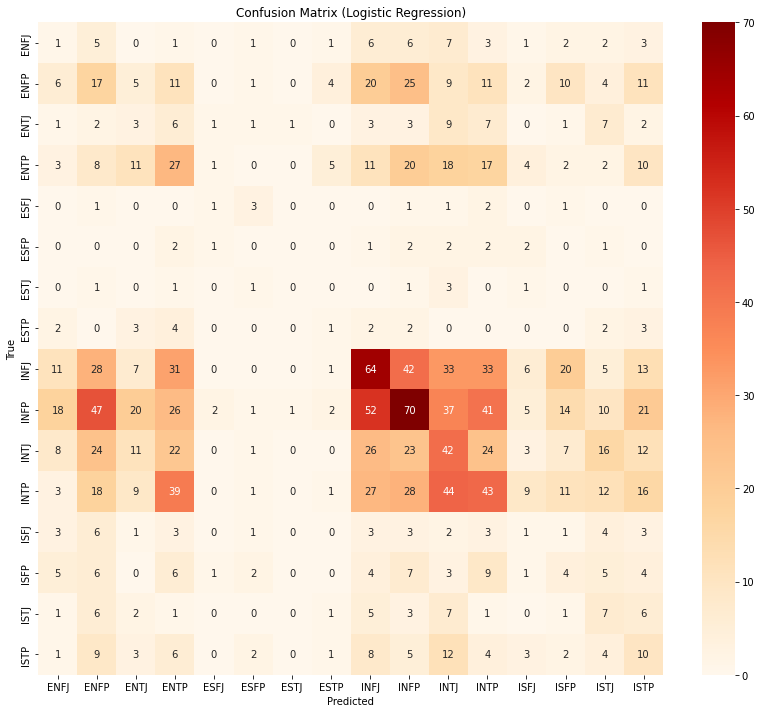

In [24]:
# plot cm
plt.figure(figsize = (14,12))
plt.title('Confusion Matrix (Logistic Regression)')
cm = confusion_matrix(y_test, y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
ax = sns.heatmap(cm, annot= True, fmt='g',cmap="OrRd", xticklabels=types_16, yticklabels= types_16)
ax.set(ylabel='True', xlabel='Predicted')

## KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_res, y_res)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        ENFJ       0.02      0.08      0.03        39
        ENFP       0.12      0.04      0.06       136
        ENTJ       0.02      0.04      0.02        47
        ENTP       0.09      0.03      0.04       139
        ESFJ       0.00      0.20      0.01        10
        ESFP       0.01      0.08      0.01        13
        ESTJ       0.00      0.00      0.00         9
        ESTP       0.01      0.11      0.02        19
        INFJ       0.00      0.00      0.00       294
        INFP       0.00      0.00      0.00       367
        INTJ       0.00      0.00      0.00       219
        INTP       0.00      0.00      0.00       261
        ISFJ       0.02      0.09      0.03        34
        ISFP       0.03      0.05      0.04        57
        ISTJ       0.03      0.10      0.04        41
        ISTP       0.04      0.03      0.03        70

    accuracy                           0.02      1755
   macro avg       0.02   

[Text(105.0, 0.5, 'True'), Text(0.5, 87.0, 'Predicted')]

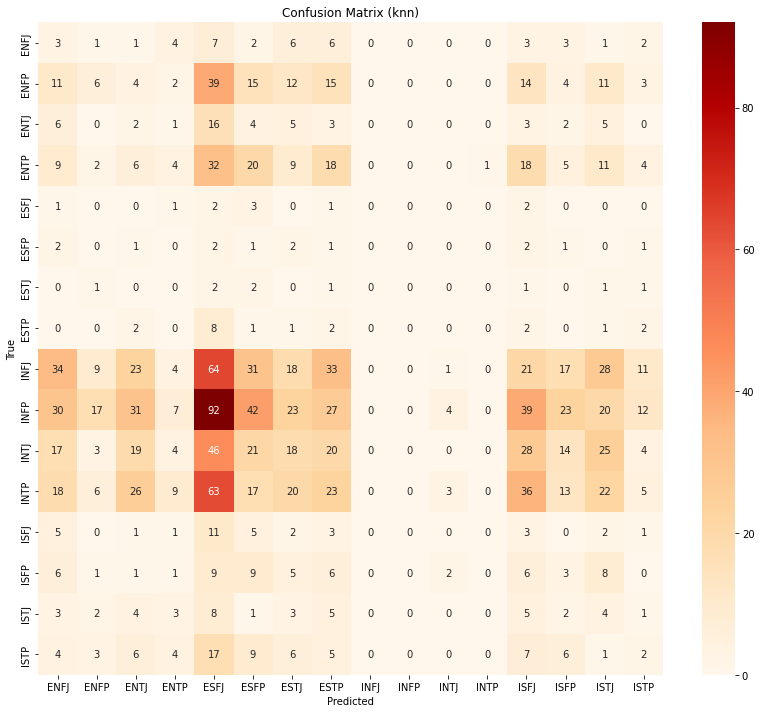

In [26]:
# plot cm
plt.figure(figsize = (14,12))
plt.title('Confusion Matrix (knn)')
cm = confusion_matrix(y_test, y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
ax = sns.heatmap(cm, annot= True, fmt='g',cmap="OrRd", xticklabels=types_16, yticklabels= types_16)
ax.set(ylabel='True', xlabel='Predicted')


## lgbm

In [27]:
import lightgbm as lgb
model = lgb.LGBMClassifier(is_unbalance=True)
model.fit(X_res, y_res)

LGBMClassifier(is_unbalance=True)

In [28]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        39
        ENFP       0.07      0.01      0.02       136
        ENTJ       0.00      0.00      0.00        47
        ENTP       0.13      0.04      0.06       139
        ESFJ       0.00      0.00      0.00        10
        ESFP       0.00      0.00      0.00        13
        ESTJ       0.00      0.00      0.00         9
        ESTP       0.00      0.00      0.00        19
        INFJ       0.20      0.31      0.24       294
        INFP       0.23      0.44      0.30       367
        INTJ       0.14      0.12      0.13       219
        INTP       0.15      0.17      0.16       261
        ISFJ       0.00      0.00      0.00        34
        ISFP       0.00      0.00      0.00        57
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.14      0.01      0.03        70

    accuracy                           0.19      1755
   macro avg       0.07   

[Text(105.0, 0.5, 'True'), Text(0.5, 87.0, 'Predicted')]

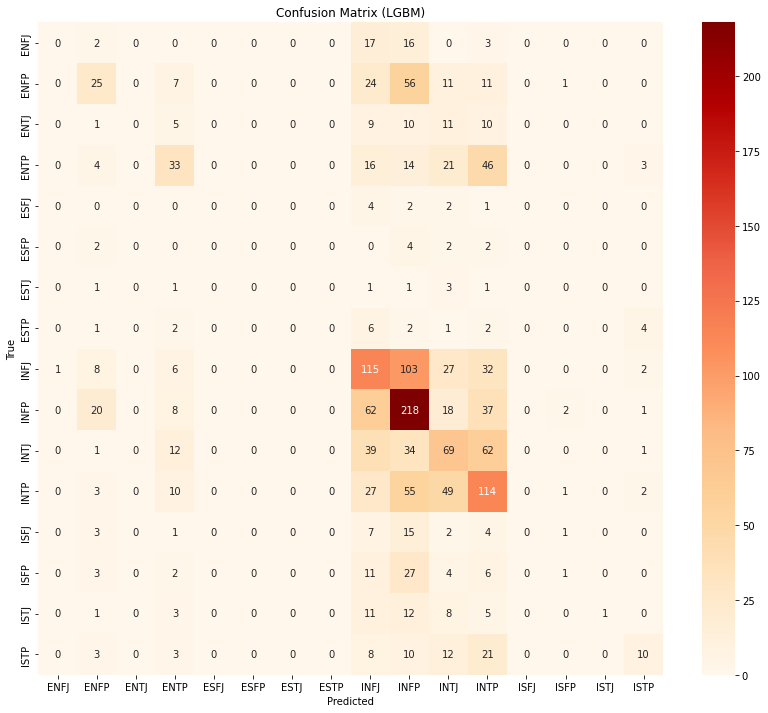

In [19]:
# plot cm
plt.figure(figsize = (14,12))
plt.title('Confusion Matrix (LGBM)')
cm = confusion_matrix(y_test, y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
ax = sns.heatmap(cm, annot= True, fmt='g',cmap="OrRd", xticklabels=types_16, yticklabels= types_16)
ax.set(ylabel='True', xlabel='Predicted')

## DNN

In [20]:
temp_data = data['MBTI_TYPE'].value_counts().reset_index().sort_values(by='index')
temp_data['class_weight'] =   temp_data['MBTI_TYPE'].sum() / (temp_data.shape[0] * temp_data['MBTI_TYPE'])
temp_data = temp_data.reset_index()
class_weights = temp_data['class_weight'].to_dict()
class_weights

{0: 2.8536184210526314,
 1: 0.8032407407407407,
 2: 2.347132034632035,
 3: 0.7915145985401459,
 4: 12.90922619047619,
 5: 11.295572916666666,
 6: 13.90224358974359,
 7: 6.091994382022472,
 8: 0.36883503401360546,
 9: 0.2959538755458515,
 10: 0.4969637946837763,
 11: 0.41578796012269936,
 12: 3.2661897590361444,
 13: 2.000691881918819,
 14: 2.644817073170732,
 15: 1.6088649851632046}

In [33]:
res = pd.DataFrame(y_res)

In [34]:
# one hot encoding
onehotencoder = OneHotEncoder()
onehot = onehotencoder.fit_transform(res).toarray()
y_train_df = pd.DataFrame(onehot)
y_train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
scaler = MinMaxScaler()
X_std = scaler.fit_transform(data.drop(['MBTI_TYPE','MBTI_LABEL'], axis= 1))
X_std

array([[0.        , 0.        , 0.        , ..., 0.        , 0.26151021,
        0.        ],
       [0.25541311, 0.        , 0.31310055, ..., 0.        , 0.19151974,
        0.        ],
       [0.28744891, 0.        , 0.35237193, ..., 0.        , 0.56244232,
        0.27105682],
       ...,
       [0.27633631, 0.25652861, 0.        , ..., 0.        , 0.49446134,
        0.26057793],
       [0.20053213, 0.        , 0.41621653, ..., 0.25437521, 0.        ,
        0.        ],
       [0.        , 0.        , 0.29618297, ..., 0.        , 0.        ,
        0.22783431]])

In [36]:
# # train test split
# X = X_std
# y = y_train_df.to_numpy()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
model = Sequential()

model.add(Dense(units=128, input_dim=500, activation='relu')) 
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu', kernel_regularizer='l2')) 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=64, activation='relu', kernel_regularizer='l2')) 
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Add output layer
model.add(Dense(units=16, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

In [38]:
model.fit(X_res, y_train_df, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
660/660 [==============================] - 9s 9ms/step - loss: 3.2661 - accuracy: 0.3647 - val_loss: 4.4560 - val_accuracy: 0.0000e+00
Epoch 2/50
660/660 [==============================] - 6s 8ms/step - loss: 1.7300 - accuracy: 0.6145 - val_loss: 3.8021 - val_accuracy: 8.5251e-04
Epoch 3/50
660/660 [==============================] - 6s 8ms/step - loss: 1.2084 - accuracy: 0.6961 - val_loss: 3.2162 - val_accuracy: 0.0818
Epoch 4/50
660/660 [==============================] - 5s 8ms/step - loss: 0.9812 - accuracy: 0.7378 - val_loss: 2.6755 - val_accuracy: 0.1756
Epoch 5/50
660/660 [==============================] - 5s 8ms/step - loss: 0.8456 - accuracy: 0.7730 - val_loss: 2.6683 - val_accuracy: 0.2161
Epoch 6/50
660/660 [==============================] - 5s 8ms/step - loss: 0.7629 - accuracy: 0.7976 - val_loss: 2.3075 - val_accuracy: 0.2609
Epoch 7/50
660/660 [==============================] - 5s 8ms/step - loss: 0.6844 - accuracy: 0.8183 - val_loss: 2.2068 - val_accuracy: 0.319

In [41]:
y_pred = model.predict(X_test)
y_pred_list = []
total_ypred_list = []
for ele in y_pred:
    empty_list = np.zeros(16)
    temp_list = list(ele)
    idx_ = temp_list.index(ele.max())
    empty_list[idx_] = 1
    total_ypred_list.append(list(empty_list))

In [49]:
y_pred_str = []
for sele in total_ypred_list:
    MBTI_idx = sele.index(1)
    y_pred_str.append(types_16[MBTI_idx])

In [50]:


print(classification_report(y_test, y_pred_str))

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.24      0.19      0.21       135
        ENTJ       0.09      0.09      0.09        46
        ENTP       0.22      0.26      0.24       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.27      0.34      0.30       294
        INFP       0.45      0.26      0.33       366
        INTJ       0.21      0.29      0.25       218
        INTP       0.30      0.38      0.33       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.14      0.07      0.10        54
        ISTJ       0.08      0.07      0.08        41
        ISTP       0.16      0.21      0.18        67

    accuracy                           0.25      1735
   macro avg       0.14   

## 1D CNN

In [51]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(500,1)))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(BatchNormalization())
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [52]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(X_train, y_train_df, validation_split=0.1, epochs=50, batch_size=32, callbacks=es)

Epoch 1/50
196/196 [==============================] - 11s 30ms/step - loss: 2.7666 - accuracy: 0.1763 - val_loss: 5.5717 - val_accuracy: 0.1297
Epoch 2/50
196/196 [==============================] - 6s 29ms/step - loss: 2.1931 - accuracy: 0.2939 - val_loss: 3.4364 - val_accuracy: 0.0605
Epoch 3/50
196/196 [==============================] - 6s 29ms/step - loss: 2.0009 - accuracy: 0.3375 - val_loss: 2.6189 - val_accuracy: 0.2017
Epoch 4/50
196/196 [==============================] - 5s 28ms/step - loss: 1.8855 - accuracy: 0.3729 - val_loss: 2.1731 - val_accuracy: 0.2752
Epoch 5/50
196/196 [==============================] - 6s 29ms/step - loss: 1.7924 - accuracy: 0.3991 - val_loss: 2.1209 - val_accuracy: 0.2954
Epoch 6/50
196/196 [==============================] - 5s 27ms/step - loss: 1.6946 - accuracy: 0.4347 - val_loss: 2.2660 - val_accuracy: 0.3357
Epoch 7/50
196/196 [==============================] - 6s 28ms/step - loss: 1.6239 - accuracy: 0.4541 - val_loss: 2.1187 - val_accuracy: 0.317

In [54]:
y_pred = model.predict(X_test)
y_pred_list = []
total_ypred_list = []
for ele in y_pred:
    empty_list = np.zeros(16)
    temp_list = list(ele)
    idx_ = temp_list.index(ele.max())
    empty_list[idx_] = 1
    total_ypred_list.append(list(empty_list))

In [55]:
y_pred_str = []
for sele in total_ypred_list:
    MBTI_idx = sele.index(1)
    y_pred_str.append(types_16[MBTI_idx])

In [56]:
print(classification_report(y_test, y_pred_str))

              precision    recall  f1-score   support

        ENFJ       0.04      0.03      0.03        38
        ENFP       0.25      0.39      0.30       135
        ENTJ       0.08      0.04      0.06        46
        ENTP       0.26      0.23      0.24       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.27      0.40      0.32       294
        INFP       0.39      0.40      0.40       366
        INTJ       0.30      0.21      0.25       218
        INTP       0.41      0.37      0.39       261
        ISFJ       0.15      0.06      0.09        33
        ISFP       0.07      0.06      0.06        54
        ISTJ       0.04      0.02      0.03        41
        ISTP       0.17      0.13      0.15        67

    accuracy                           0.29      1735
   macro avg       0.15   